In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io

In [2]:
# identify and specify the GPU as the device, later in training loop we will load data into device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    print("cuda is available")
    torch.cuda.manual_seed_all(SEED)

cuda is available


In [3]:
df_train = pd.read_csv("train.txt", delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv("test.txt", delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv("val.txt", delimiter=';', header=None, names=['sentence','label'])

df = pd.concat([df_train,df_test,df_val])
df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [4]:
df = df.loc[df['label'].isin(['anger', 'surprise', 'joy', 'sadness'])]
print(df)
print(df['label'].unique())

                                               sentence    label
0                               i didnt feel humiliated  sadness
1     i can go from feeling so hopeless to so damned...  sadness
2      im grabbing a minute to post i feel greedy wrong    anger
4                                  i am feeling grouchy    anger
5     ive been feeling a little burdened lately wasn...  sadness
...                                                 ...      ...
1995  im having ssa examination tomorrow in the morn...  sadness
1996  i constantly worry about their fight against n...      joy
1997  i feel its important to share this info for th...      joy
1998  i truly feel that if you are passionate enough...      joy
1999  i feel like i just wanna buy any cute make up ...      joy

[15986 rows x 2 columns]
['sadness' 'anger' 'surprise' 'joy']


In [5]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['label'])
df[['label','label_enc']].drop_duplicates(keep='first')

C:\Users\USER\AppData\Local\Temp\ipykernel_2712\1705834920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_enc'] = labelencoder.fit_transform(df['label'])


,label,label_enc
0,sadness,2
2,anger,0
6,surprise,3
8,joy,1


In [6]:
df.rename(columns={'label':'label_desc'},inplace=True)
df.rename(columns={'label_enc':'label'},inplace=True)
df

C:\Users\USER\AppData\Local\Temp\ipykernel_2712\1850276317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'label':'label_desc'},inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_2712\1850276317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'label_enc':'label'},inplace=True)


,sentence,label_desc,label
0,i didnt feel humiliated,sadness,2
1,i can go from feeling so hopeless to so damned...,sadness,2
2,im grabbing a minute to post i feel greedy wrong,anger,0
4,i am feeling grouchy,anger,0
5,ive been feeling a little burdened lately wasn...,sadness,2
...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,2
1996,i constantly worry about their fight against n...,joy,1
1997,i feel its important to share this info for th...,joy,1
1998,i truly feel that if you are passionate enough...,joy,1


In [7]:
## create label and sentence list
sentences = df.sentence.values
print(sentences)

#check distribution of data based on labels
print("Distribution of data based on labels: ",df.label.value_counts())

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences]
labels = df.label.values

print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])

## Create attention mask
attention_masks = []
## Create a mask of 1 for all input tokens and 0 for all padding tokens
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

['i didnt feel humiliated'
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'
 'im grabbing a minute to post i feel greedy wrong' ...
 'i feel its important to share this info for those that experience the same thing'
 'i truly feel that if you are passionate enough about something and stay true to yourself you will succeed'
 'i feel like i just wanna buy any cute make up i see online or even the one']
Distribution of data based on labels:  label
1    6761
2    5797
0    2709
3     719
Name: count, dtype: int64


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\USER\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Actual sentence before tokenization:  im grabbing a minute to post i feel greedy wrong
Encoded Input from dataset:  [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0

In [8]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [9]:
# convert all our data into torch tensors, required data type for our model
train_inputs = torch.tensor(train_inputs, dtype=torch.long)
validation_inputs = torch.tensor(validation_inputs, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [10]:
print(train_data[0])
print(type(train_dataloader))

(tensor([ 101, 1045, 2085, 2514, 2471, 5295, 2000, 1996, 3279, 1997, 1996, 8069,
        1998, 5544, 1045, 2320, 2018,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  

In [11]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4).to(device)

# Parameters:
lr = 2e-5
adam_epsilon = 1e-8

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs

### In Transformers, optimizer and schedules are splitted and instantiated like this:
optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USER\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

C:\Users\USER\AppData\Local\Temp\ipykernel_2712\607062713.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(1,epochs+1,desc='Epoch'):


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Current Learning rate:  1.3333333333333333e-05

	Average Training loss: 0.22169498361220272

	Validation Accuracy: 0.97375

	Validation MCC Accuracy: 0.9604077816974926
Confusion matrix, without normalization
[[280   3   3   0]
 [  3 654   1   5]
 [ 20   4 568   0]
 [  2   1   0  55]]
<====================== Epoch 2 ======================>

	Current Learning rate:  6.666666666666667e-06

	Average Training loss: 0.04490769768809615

	Validation Accuracy: 0.979375

	Validation MCC Accuracy: 0.9681692015204374
Confusion matrix, without normalization
[[268   3  15   0]
 [  0 661   2   0]
 [  4   2 586   0]
 [  1   6   0  51]]
<====================== Epoch 3 ======================>


C:\Users\USER\AppData\Local\Temp\ipykernel_2712\3891102121.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



	Current Learning rate:  0.0

	Average Training loss: 0.023586853189853072

	Validation Accuracy: 0.9805833333333334

	Validation MCC Accuracy: 0.9696226611268526
Confusion matrix, without normalization
[[276   3   7   0]
 [  0 661   2   0]
 [ 12   0 580   0]
 [  2   5   0  51]]


C:\Users\USER\AppData\Local\Temp\ipykernel_2712\3891102121.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


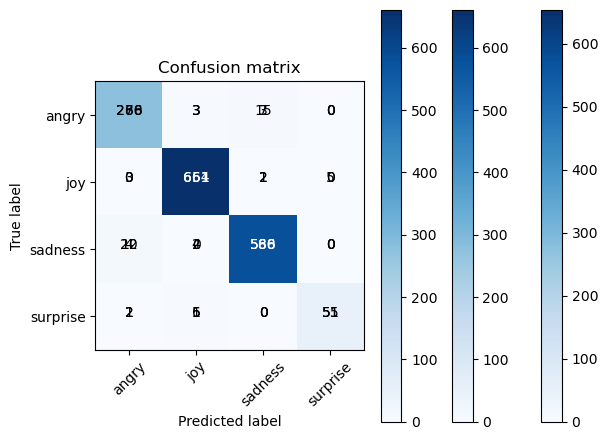

In [13]:
## Store our loss and accuracy for plotting
train_loss_set = []
learning_rate = []

# Gradients gets accumulated by default
model.zero_grad()

# tnrange is a tqdm wrapper around the normal python range
for _ in tnrange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
  # Calculate total loss for this epoch
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    
    # Backward pass
    loss.backward()
    
    # Clip the norm of the gradients to 1.0
    # Gradient clipping is not in AdamW anymore
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update learning rate schedule
    scheduler.step()

    # Clear the previous accumulated gradients
    optimizer.zero_grad()
    
    # Update tracking variables
    batch_loss += loss.item()

  # Calculate the average loss over the training data.
  avg_train_loss = batch_loss / len(train_dataloader)

  #store the current learning rate
  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])
    
  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()
  all_label_ids = []
  all_pred_flat = []
  
  # Tracking variables 
  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    all_label_ids.extend(labels_flat)
    all_pred_flat.extend(pred_flat)
    
    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    
    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')
  cm = confusion_matrix(all_label_ids, all_pred_flat)

  # 클래스 이름 (라벨에 해당하는 클래스 이름을 리스트로 제공해야 함)
  class_names = ['angry', 'joy', 'sadness', 'surprise'] # 실제 클래스 이름으로 대체 필요

  # confusion matrix 시각화
  plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')


In [14]:
## Now let's save our model and tokenizer to a directory
model.save_pretrained('./model')
tokenizer.save_pretrained('./model/tokenizer/')

model_save_name = 'fineTuneModel.pt'
path = path_model = F'./model/{model_save_name}'
torch.save(model.state_dict(),path)

# Model 불러와서 학습 진행

In [15]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# model_path = './model/'
# tokenizer_path = './model/tokenizer/'

# # 모델 불러오기
# model = AutoModelForSequenceClassification.from_pretrained(model_path)

# # 토크나이저 불러오기
# tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [16]:
text = "i really like this pizza"

# 텍스트를 토큰으로 변환하고 PyTorch 텐서로 변환
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# GPU 사용 설정 (사용 가능한 경우)
inputs = {k:v.to(device) for k,v in inputs.items()}

# 추론 모드 설정
model.eval()

# 모델에 입력 데이터 전달하여 로짓(logit) 출력 받기
with torch.no_grad():
    outputs = model(**inputs)

# 로짓을 확률로 변환하기 위해 softmax 함수 사용
logits = outputs.logits
predictions = torch.softmax(logits, dim=-1)

# 가장 높은 확률을 가진 클래스의 인덱스 추출
predicted_class_idx = predictions.argmax(-1).item()

# 예측된 클래스 인덱스를 라벨로 변환 (라벨 목록 필요)
label_names = ['anger', 'joy', 'sadness', 'surprise']  # 예시, 실제 라벨 목록으로 대체 필요
predicted_label = label_names[predicted_class_idx]

print(f"Predicted label: {predicted_label}")

Predicted label: joy


In [17]:
def get_emotion(text):
    # 텍스트를 토큰으로 변환하고 PyTorch 텐서로 변환
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # GPU 사용 설정 (사용 가능한 경우)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    # 추론 모드 설정
    model.eval()
    # 모델에 입력 데이터 전달하여 로짓(logit) 출력 받기
    with torch.no_grad():
        outputs = model(**inputs)
    # 로짓을 확률로 변환하기 위해 softmax 함수 사용
    logits = outputs.logits
    predictions = torch.softmax(logits, dim=-1)
    # 가장 높은 확률을 가진 클래스의 인덱스 추출
    predicted_class_idx = predictions.argmax(-1).item()
    # 예측된 클래스 인덱스를 라벨로 변환 (라벨 목록 필요)
    label_names = ['anger', 'joy', 'sadness', 'surprise']  # 예시, 실제 라벨 목록으로 대체 필요
    predicted_label = label_names[predicted_class_idx]
    return predicted_label    
    

In [18]:
import csv
import json
import pandas as pd
from datetime import datetime

json_file_path = 'review.json'
# CSV 파일 경로
csv_file_path = 'reviews_philadelphia.csv'

# CSV 파일을 쓰기 모드로 열기
with open(csv_file_path, 'w', newline='') as csv_file:
    # CSV 라이터 생성
    csv_writer = csv.writer(csv_file)
    # CSV 파일 헤더 작성
    csv_writer.writerow(['user_id', 'business_id','date', 'stars', 'emotion'])
    with open(json_file_path, 'r', encoding='utf-8') as json_file:
            for line in json_file:
                data = json.loads(line)  # JSON 데이터 파싱
                if data['city'] == 'philadelphia':
                    # user_id와 business_id 추출
                    user_id = data['user_id']
                    business_id = data['business_id']
                    date_time_str = data['date']
                    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
                    stars = data['stars']
                    
                    text = data['text']
                    emotion = get_emotion(text)
                    

                    date = int(date_time_obj.timestamp())
                    #print(date_time_str, date_time_obj)
                    # CSV 파일에 데이터 작성
                    #print(text)
                    #print(stars, emotion)
                    
                    csv_writer.writerow([user_id, business_id, date, stars, emotion])

KeyError: 'city'